In [31]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import os
import gzip
import numpy as np
import scanpy as sc
import squidpy as sq
import cupy as cp
import cupyx
from cupyx.scipy.sparse import csr_matrix 
import os
import time
import rapids_singlecell as rsc
import numpy as np
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator
import cupy

rmm.reinitialize(
    managed_memory=False,  # Allows oversubscription
    pool_allocator=False,  # default is False
    devices=0,  # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)
import zarr
import pickle
from collections import OrderedDict
from scipy.sparse import csr_matrix
import pandas as pd
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
from scipy.sparse import csr_matrix
import scipy
import anndata
from collections import OrderedDict
from rsc_functions.utility.applyqc import applyqc
from rsc_functions.reports.plot import plot_spatial,plot_spatial_data, plot_dist
from rsc_functions.utility.rank_genes_groups import return_markers,rank_genes_groups
from rsc_functions.reports.plot import plot_expression

In [32]:
path_016 = "/data/kanferg/Sptial_Omics/playGround/Data/Visium_HD_Human_Colon_Cancer_binned_outputs/binned_outputs/square_016um"
pathout = "/data/kanferg/Sptial_Omics/SpatialOmicsToolkit/out_2"

In [33]:
def parquet_to_csv(path):
    '''
    Converts a Parquet file to a CSV file if the CSV file does not already exist.
    '''
    file_path = os.path.join(path,'spatial/tissue_positions_list.csv')
    if not os.path.exists(file_path):
        df = pd.read_parquet(os.path.join(path,'spatial/tissue_positions.parquet'))
        # Write to a CSV file
        df.to_csv(os.path.join(path,'spatial/tissue_positions_list.csv'), index=False)
    return
parquet_to_csv(path_016)
andata = sc.read_visium(path=path_016)
rsc.get.anndata_to_GPU(andata)
andata.obsm['spatial'] = np.array(andata.obsm['spatial'], dtype=np.float64)
andata.var_names_make_unique()
andata.uns['config'] = OrderedDict()
andata.uns["config"]["secondary_var_names"] = andata.var_names
rsc.pp.flag_gene_family(andata, gene_family_name="MT", gene_family_prefix="MT-")
rsc.pp.calculate_qc_metrics(andata, qc_vars=["MT"])
rsc.pp.filter_cells(andata, min_count=1000,qc_var = 'total_counts')
rsc.pp.filter_genes(andata, min_count=50)
rsc.pp.filter_genes(andata, max_count=50_000)
andata.layers['counts'] = andata.X.copy()
rsc.pp.normalize_total(andata)
# rsc.pp.log1p(andata)
# andata.layers['log'] = andata.X.copy()

/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/readwrite.py:476: DtypeWarning: Columns (1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  positions = pd.read_csv(


filtered out 52329 cells
filtered out 1143 genes based on n_cells_by_counts
filtered out 253 genes based on n_cells_by_counts


from kory
```r
group1 <- Final.working.data[,c(1:4)]
g1.mean <- apply(group1,1,mean)
g1.sd <- apply(group1,1,sd)
g1.cv <- (g1.sd/g1.mean)*100
lowess.g1 <- lowess(g1.cv~g1.mean)

group2 <- Final.working.data[,c(5:8)]
g2.mean <- apply(group2,1,mean)
g2.sd <- apply(group2,1,sd)
g2.cv <- (g2.sd/g2.mean)*100
lowess.g2 <- lowess(g2.cv~g2.mean)
```

In [4]:
import cupy as cp
import cupyx.scipy.sparse as sparse

# Assuming your sparse matrix is in CSR format
sparse_data = andata.X  # Example: andata.X as the sparse matrix in CSR format (CSR format)

def sparse_mean_variance_covariance_csr(sparse_data):
    # Get non-zero data from the sparse matrix
    data = sparse_data.data        # Non-zero elements
    indices = sparse_data.indices  # Column indices of the non-zero elements
    indptr = sparse_data.indptr    # Points to the start of each row in data
    
    # Initialize arrays for mean, variance, and covariance
    num_cols = sparse_data.shape[1]
    col_sum = cp.zeros(num_cols)
    col_count = cp.zeros(num_cols)
    col_sum_sq_diff = cp.zeros(num_cols)  # For variance calculation
    
    # Iterate over rows
    for i in range(sparse_data.shape[0]):
        # Get the non-zero elements in the current row
        row_start = indptr[i]
        row_end = indptr[i + 1]
        row_data = data[row_start:row_end]
        row_indices = indices[row_start:row_end]
        
        # Update column sums and counts for the non-zero elements
        col_sum[row_indices] += row_data
        col_count[row_indices] += 1
    
    # Compute mean: sum divided by the count of non-zero elements
    col_mean = col_sum / col_count
    
    # Compute variance: (data - mean)^2 sum
    for i in range(sparse_data.shape[0]):
        # Get the non-zero elements in the current row
        row_start = indptr[i]
        row_end = indptr[i + 1]
        row_data = data[row_start:row_end]
        row_indices = indices[row_start:row_end]
        
        # Compute squared difference from the mean
        sq_diff = (row_data - col_mean[row_indices]) ** 2
        col_sum_sq_diff[row_indices] += sq_diff
    
    # Compute variance: sum of squared differences divided by count of non-zero elements
    col_variance = col_sum_sq_diff / col_count
    
    # Compute covariance: variance divided by mean (avoid division by zero)
    epsilon = 1e-10  # Small value to prevent division by zero
    col_covariance = (col_variance / (col_mean + epsilon))*100
    
    return col_mean, col_variance, col_covariance

# Run the function
mean, variance, covariance = sparse_mean_variance_covariance_csr(sparse_data)

# Output the result
print("Column-wise mean:", mean)
print("Column-wise variance:", variance)
print("Column-wise covariance (variance/mean):", covariance)


Column-wise mean: [0.96633663 0.62659459 0.66786647 ... 0.92683277 0.9579316  0.91740612]
Column-wise variance: [0.06044308 0.0481873  0.05204629 ... 0.04784463 0.07368598 0.06580089]
Column-wise covariance (variance/mean): [6.25486813 7.69034666 7.79291855 ... 5.16216466 7.69219678 7.17249267]


In [5]:
print("Column-wise mean:", len(mean))
print("Column-wise variance:", len(variance))
print("Column-wise covariance (variance/mean):", len(covariance))

Column-wise mean: 16689
Column-wise variance: 16689
Column-wise covariance (variance/mean): 16689


In [37]:
df_var = pd.DataFrame({'mean':mean.get(),'variance':variance.get(),'covariance':covariance.get()})

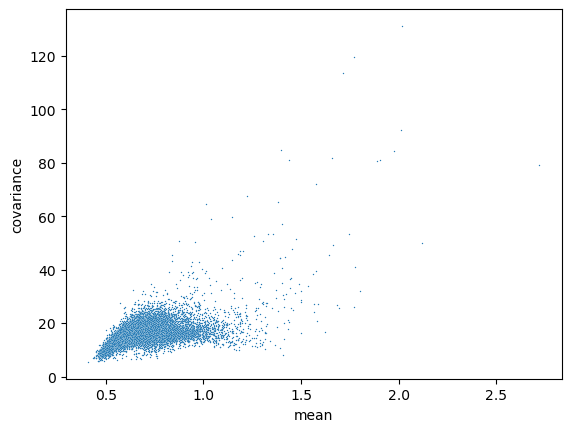

In [38]:
ax = sns.scatterplot(
    data=df_var, x='mean', y="covariance", s=1
)

In [28]:
andata

AnnData object with n_obs × n_vars = 133282 × 16689
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_MT', 'pct_counts_MT', 'log1p_total_counts_MT'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts'
    uns: 'spatial', 'config', 'log1p'
    obsm: 'spatial'
    layers: 'counts', 'log'

In [59]:
rsc.pp.highly_variable_genes(andata,flavor="seurat_v3",n_samples = 10_000,layer='log')

/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/rapids_singlecell/preprocessing/_hvg.py:502: UserWarning: `flavor='seurat_v3'` expects `n_top_genes`  to be defined, defaulting to 2000 HVGs
  warnings.warn(
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/rapids_singlecell/preprocessing/_hvg.py:517: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [60]:
andata

AnnData object with n_obs × n_vars = 84722 × 16689
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_MT', 'pct_counts_MT', 'log1p_total_counts_MT'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'config', 'log1p', 'hvg'
    obsm: 'spatial'
    layers: 'counts', 'log'

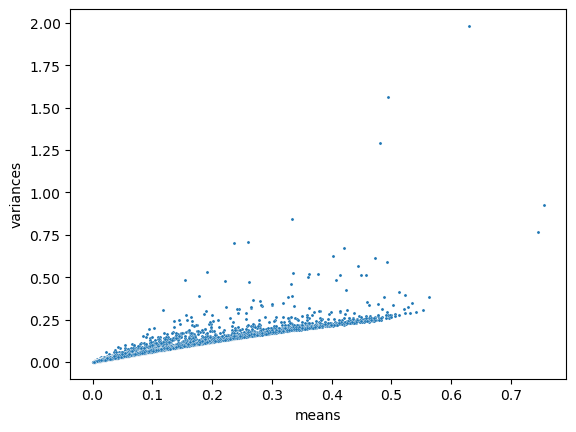

In [61]:
ax = sns.scatterplot(
    data=andata.var, x='means', y="variances", s=5
)
# ax.set_xlim(None, 1.5)
# ax.set_ylim(None, 3)
# ax.set_xlim

In [35]:
andata

AnnData object with n_obs × n_vars = 84722 × 16689
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_MT', 'pct_counts_MT', 'log1p_total_counts_MT'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts'
    uns: 'spatial', 'config'
    obsm: 'spatial'
    layers: 'counts'

In [36]:
rsc.pp.highly_variable_genes(andata,flavor="seurat")

ValueError: cannot specify integer `bins` when input data contains infinity

In [44]:
andata.var['means']

SAMD11     0.006565
NOC2L      0.021378
KLHL17     0.006042
PLEKHN1    0.010025
PERM1      0.000248
             ...   
UTY        0.026544
TMSB4Y     0.001102
NLGN4Y     0.001978
KDM5D      0.049906
EIF1AY     0.039616
Name: means, Length: 16689, dtype: float64

In [2]:
import scanpy as sc

In [3]:
andata = sc.read_h5ad("andata_sim_16by6.h5ad")

In [8]:
mean = np.mean(andata.X,axis=0)

In [9]:
var = np.var(andata.X,axis=0)

In [10]:
covar = var/mean

In [11]:
df_var = pd.DataFrame({'mean':mean,'variance':var,'covariance':covar})

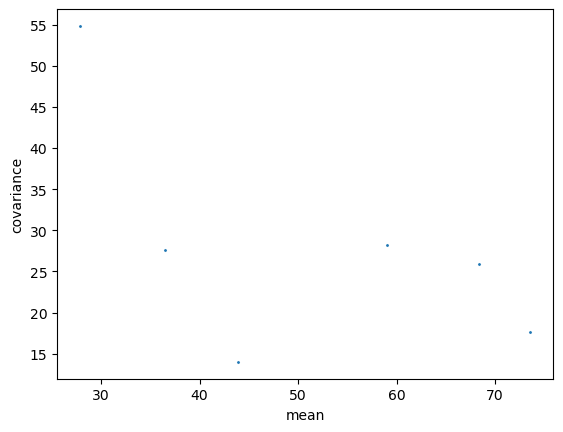

In [13]:
ax = sns.scatterplot(
    data=df_var, x='mean', y="covariance", s=5
)

In [14]:
mean

array([36.45445548, 43.91437313, 73.59613831, 59.02196882, 68.41920408,
       27.82385096])

In [6]:
from anndata import AnnData

In [7]:
counts = pd.read_csv('Rsim_count.csv')

In [8]:
pd.read_csv('Rsim_centroids.csv').loc[:,['x','y']].to_numpy()

array([[440.63907908, 381.09812294],
       [259.63097204, 126.32763711],
       [183.07831414, 427.76779151],
       ...,
       [208.41584876, 352.43025516],
       [250.72008064, 503.73539089],
       [284.29343913, 148.10981608]])

In [9]:
adata = AnnData(counts.iloc[:,1:].to_numpy(), obsm={"spatial": pd.read_csv('Rsim_centroids.csv').loc[:,['x','y']].to_numpy()})

In [10]:
mean = np.mean(adata.X,axis=1)
var = np.var(adata.X,axis=1)
covar = var + var/mean
df_var = pd.DataFrame({'mean':mean,'variance':var,'covariance':covar})

In [11]:
covar

array([1545.2205762 ,   39.76231413,  295.16625881, ...,  221.59609914,
        116.8660513 ,  857.7645614 ])

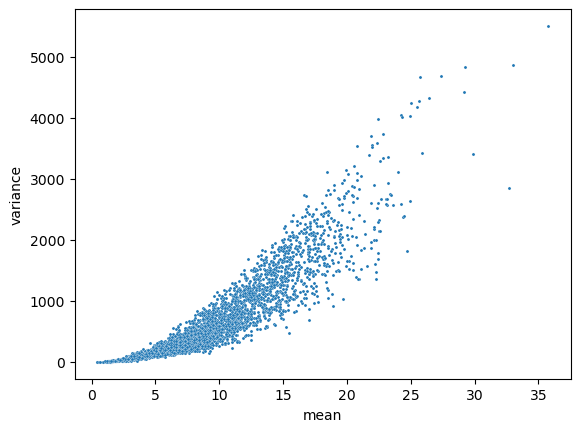

In [13]:
ax = sns.scatterplot(
    data=df_var, x='mean', y="variance", s=5
)

In [14]:
from skmisc.loess import loess

In [24]:
len(mean)

3611

In [25]:
estimat_var = cp.zeros(adata.shape[0], dtype=np.float64)
not_const = var > 0

In [26]:
model = loess(mean, var, span=0.3, degree=2)
model.fit()
estimat_var[not_const] = model.outputs.fitted_values

In [27]:
reg_std = cp.sqrt(10**estimat_var)

In [28]:
rsc.get.anndata_to_GPU(adata)
rsc.pp.highly_variable_genes(adata,flavor="seurat")

In [29]:
adata

AnnData object with n_obs × n_vars = 3611 × 80
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    obsm: 'spatial'

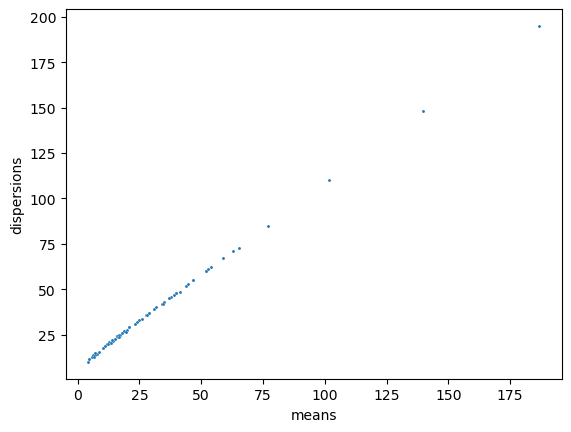

In [30]:
ax = sns.scatterplot(
    data=adata.var, x='means', y="dispersions", s=5
)